# SVD sobre MovieLens 100k (todos los ratings)
Este cuaderno carga todos los ficheros de ratings disponibles en la carpeta, construye la matriz usuario-ítem, aplica SVD, reconstruye las puntuaciones y calcula el RMSE sobre las entradas observadas.

In [1]:
# Importar librerías
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from math import sqrt
import umap
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA

print('Librerías importadas')

c:\Users\Virus\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Librerías importadas


In [2]:

search_dirs = ['.', 'ml-100k']
patterns = ['u*.base', 'u*.test', 'u*.data', '*.base', '*.test', 'u.data']
file_paths = []
for d in search_dirs:
    if os.path.isdir(d):
        for pat in patterns:
            file_paths.extend(glob.glob(os.path.join(d, pat)))
# Deduplicar y ordenar
file_paths = sorted(set(file_paths))
print('Ficheros de ratings detectados (rutas):')
for p in file_paths:
    print(' -', p)

rows = []
for path in file_paths:
    try:
        with open(path, 'r', encoding='latin-1') as fh:
            for line in fh:
                parts = line.strip().split()
                if len(parts) >= 3:
                    try:
                        uid = int(parts[0])
                        iid = int(parts[1])
                        rating = float(parts[2])
                        rows.append((uid, iid, rating))
                    except ValueError:
                        # ignorar líneas mal formadas
                        pass
    except FileNotFoundError:
        pass

if len(rows) == 0:
    raise RuntimeError('No se encontraron ratings en los caminos buscados.')

# Crear dataframe
df = pd.DataFrame(rows, columns=['user', 'item', 'rating'])
print('Ratings cargados, filas:', len(df))
df.head()

Ficheros de ratings detectados (rutas):
 - ml-100k\u.data
 - ml-100k\u1.base
 - ml-100k\u1.test
 - ml-100k\u2.base
 - ml-100k\u2.test
 - ml-100k\u3.base
 - ml-100k\u3.test
 - ml-100k\u4.base
 - ml-100k\u4.test
 - ml-100k\u5.base
 - ml-100k\u5.test
 - ml-100k\ua.base
 - ml-100k\ua.test
 - ml-100k\ub.base
 - ml-100k\ub.test
Ratings cargados, filas: 800000


,user,item,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [3]:
# Construir matriz usuario-ítem (1-based ids en ML-100k)
n_users = int(df['user'].max())
n_items = int(df['item'].max())
R = np.zeros((n_users, n_items), dtype=np.float32)
mask = np.zeros_like(R, dtype=bool)
for row in df.itertuples(index=False):
    u, i, r = row
    R[u-1, i-1] = r
    mask[u-1, i-1] = True
print(f'Matriz creada: usuarios={n_users}, items={n_items}, ratings observados={mask.sum()}')

Matriz creada: usuarios=943, items=1682, ratings observados=100000


## Imputación simple y cálculo de SVD
Rellenamos los entries faltantes con la media del usuario y aplicamos svds de SciPy.

In [4]:
# Calcular medias por usuario (evitar división por cero)
user_means = np.zeros(n_users, dtype=np.float32)
for u in range(n_users):
    idx = mask[u]
    if idx.sum() > 0:
        user_means[u] = R[u, idx].mean()
    else:
        user_means[u] = 0.0
# Crear matriz imputada
R_filled = R.copy()
for u in range(n_users):
    missing = ~mask[u]
    if missing.any():
        R_filled[u, missing] = user_means[u]
# Elegir k (componentes latentes)
k = min(50, min(R_filled.shape)-1)
print('Usando k =', k)
U, s, Vt = svds(R_filled, k=k)
# ordenar componentes por valor singular descendente
idx = np.argsort(s)[::-1]
s = s[idx]
U = U[:, idx]
Vt = Vt[idx, :]
Sigma = np.diag(s)
R_pred = U.dot(Sigma).dot(Vt)
# Calcular RMSE sobre entradas observadas
diff = (R_pred[mask] - R[mask])
rmse = np.sqrt(np.mean(diff**2))
print(f'RMSE sobre entradas observadas: {rmse:.4f}')

Usando k = 50
RMSE sobre entradas observadas: 0.7280


In [5]:
# Cargar títulos de películas desde u.item (si existe)
movies = {}
if os.path.exists('u.item'):
    with open('u.item', 'r', encoding='latin-1') as fh:
        for line in fh:
            parts = line.strip().split('|')
            if len(parts) >= 2:
                try:
                    mid = int(parts[0])
                    title = parts[1]
                    movies[mid] = title
                except ValueError:
                    pass
else:
    print('No se encontró u.item; los títulos no estarán disponibles.')
# Función para mostrar recomendaciones para un usuario de ejemplo
def top_n_for_user(user_id, n=10):
    u_idx = user_id - 1
    scores = R_pred[u_idx]
    known = mask[u_idx]
    # ordenar por score descendente, excluir ya conocidos
    candidates = [(i+1, scores[i]) for i in range(len(scores)) if not known[i]]
    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[:n]
# Mostrar top-10 para user 1
recommendations = top_n_for_user(1, n=10)
print('Top recomendaciones (id, score, título si disponible):')
for mid, score in recommendations:
    print(mid, f'{score:.3f}', movies.get(mid, ''))

No se encontró u.item; los títulos no estarán disponibles.
Top recomendaciones (id, score, título si disponible):
318 4.609 
357 4.362 
317 4.340 
455 4.328 
285 4.313 
328 4.311 
511 4.279 
425 4.220 
462 4.213 
305 4.209 


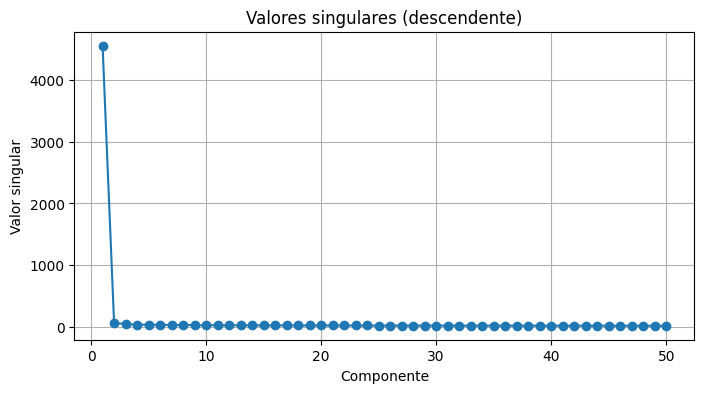

In [6]:
# Visualizar los valores singulares
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, len(s)+1), s, marker='o')
plt.title('Valores singulares (descendente)')
plt.xlabel('Componente')
plt.ylabel('Valor singular')
plt.grid(True)
plt.show()

### Guardar resultados (opcional)
Se guardan matrices U, s, Vt para análisis posterior.

In [7]:
np.save('U.npy', U)
np.save('s.npy', s)
np.save('Vt.npy', Vt)
print('Matrices guardadas: U.npy, s.npy, Vt.npy')

Matrices guardadas: U.npy, s.npy, Vt.npy


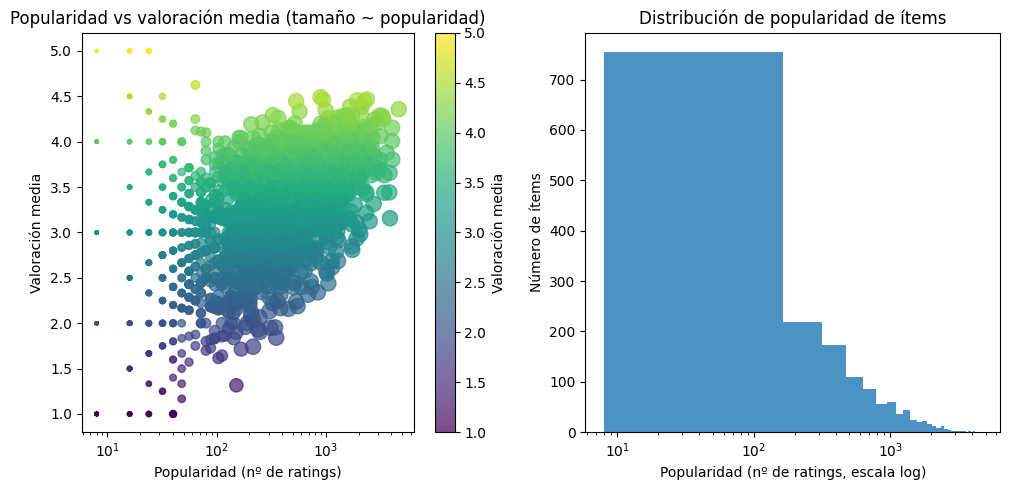


Top 15 ítems por popularidad:
  50  pop=4664  avg=4.358  
 258  pop=4072  avg=3.804  
 100  pop=4064  avg=4.156  
 181  pop=4056  avg=4.008  
 294  pop=3880  avg=3.157  
 286  pop=3848  avg=3.657  
 288  pop=3824  avg=3.441  
   1  pop=3616  avg=3.878  
 300  pop=3448  avg=3.631  
 121  pop=3432  avg=3.438  
 174  pop=3360  avg=4.252  
 127  pop=3304  avg=4.283  
  56  pop=3152  avg=4.061  
   7  pop=3136  avg=3.798  
  98  pop=3120  avg=4.290  


In [8]:

item_stats = df.groupby('item')['rating'].agg(['count', 'mean']).rename(columns={'count':'popularity','mean':'avg_rating'})
item_stats = item_stats.sort_values('popularity', ascending=False)
item_stats.index = item_stats.index.astype(int)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sc = plt.scatter(item_stats['popularity'], item_stats['avg_rating'],
                s=np.clip(item_stats['popularity'], 5, 200)*0.6,
                c=item_stats['avg_rating'], cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='Valoración media')
plt.xlabel('Popularidad (nº de ratings)')
plt.ylabel('Valoración media')
plt.title('Popularidad vs valoración media (tamaño ~ popularidad)')
plt.xscale('log')

# Histograma de popularidad
plt.subplot(1,2,2)
plt.hist(item_stats['popularity'], bins=30, color='C0', alpha=0.8)
plt.xscale('log')
plt.xlabel('Popularidad (nº de ratings, escala log)')
plt.ylabel('Número de ítems')
plt.title('Distribución de popularidad de ítems')
plt.tight_layout()
plt.show()

# Mostrar top-15 ítems más populares con títulos si están disponibles
print('\nTop 15 ítems por popularidad:')
for item_id, row in item_stats.head(15).iterrows():
    title = movies.get(int(item_id), '')
    print(f"{int(item_id):4d}  pop={int(row['popularity']):4d}  avg={row['avg_rating']:.3f}  {title}")

# Interpretación (resumen)

- Datos: se han unido todos los ratings disponibles.
- Matriz: `n_users x n_items`, muy dispersa.
- SVD: factoriza la matriz; RMSE calculado sobre observados (optimista).
- Valores singulares: indican importancia de factores; elegir `k` antes del "codo".
- Recomendaciones: predicciones pueden favorecer ítems populares.
- Popularidad: distribución con cola larga; cuidado con medias de ítems poco votados.


Primeras 5 filas del dataset:


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


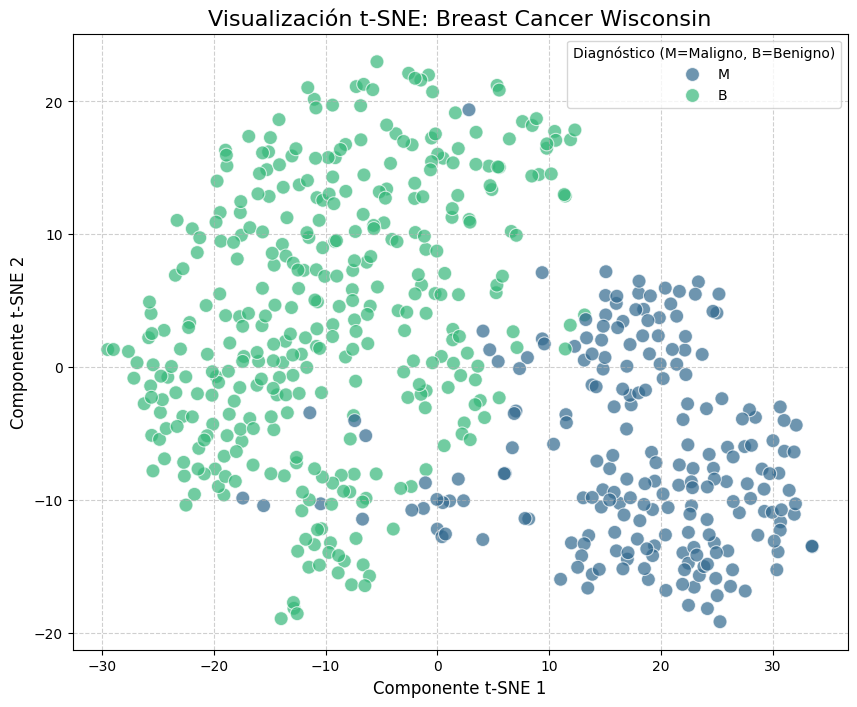

In [9]:
#============================================================
#                   T-SNE
#=============================================================

df = pd.read_csv("data.csv")


print("Primeras 5 filas del dataset:")
display(df.head())

cols_to_drop = ['id', 'Unnamed: 32']
df_clean = df.drop([col for col in cols_to_drop if col in df.columns], axis=1)


X = df_clean.drop('diagnosis', axis=1)  
y = df_clean['diagnosis']               

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(data=X_tsne, columns=['Dimensión 1', 'Dimensión 2'])
tsne_df['Diagnóstico'] = y

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dimensión 1', 
    y='Dimensión 2', 
    hue='Diagnóstico', 
    data=tsne_df, 
    palette='viridis', 
    alpha=0.7,
    s=100 
)

plt.title('Visualización t-SNE: Breast Cancer Wisconsin', fontsize=16)
plt.xlabel('Componente t-SNE 1', fontsize=12)
plt.ylabel('Componente t-SNE 2', fontsize=12)
plt.legend(title='Diagnóstico (M=Maligno, B=Benigno)')
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar el gráfico
plt.show()

In [10]:
#============================================================
#                      UMAP
#============================================================

umap_model = umap.UMAP(
    n_neighbors=15,      
    min_dist=0.1,       
    n_components=2,      
    random_state=42
)

X_umap = umap_model.fit_transform(X_scaled)

c:\Users\Virus\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [11]:
umap_df = pd.DataFrame(data=X_umap, columns=['Dimensión 1', 'Dimensión 2'])
umap_df['Diagnóstico'] = y

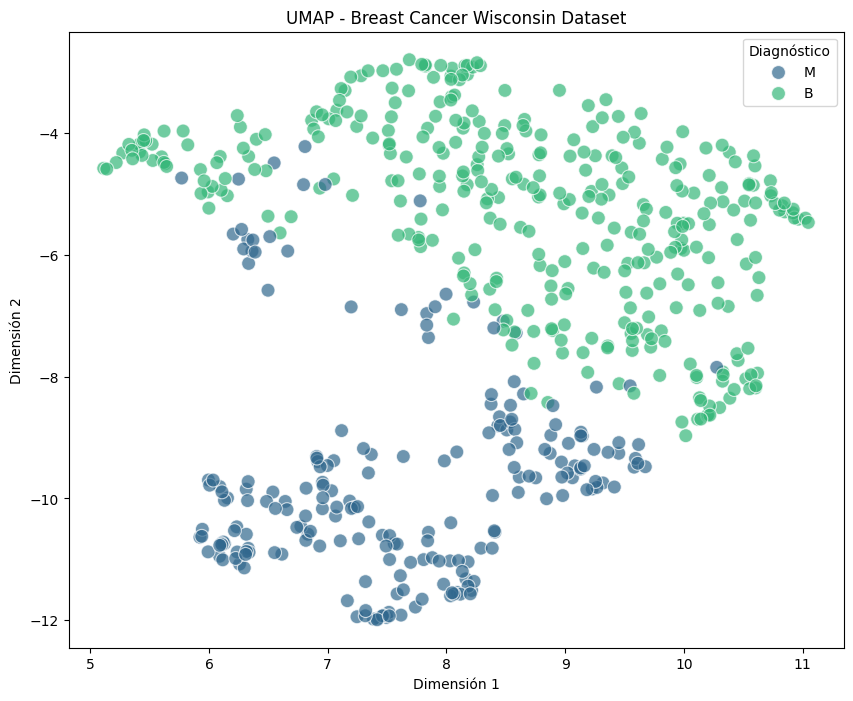

In [12]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x='Dimensión 1',
    y='Dimensión 2',
    hue='Diagnóstico',
    data=umap_df,
    palette='viridis',
    alpha=0.7,
    s=100
)

plt.title("UMAP - Breast Cancer Wisconsin Dataset")
plt.show()

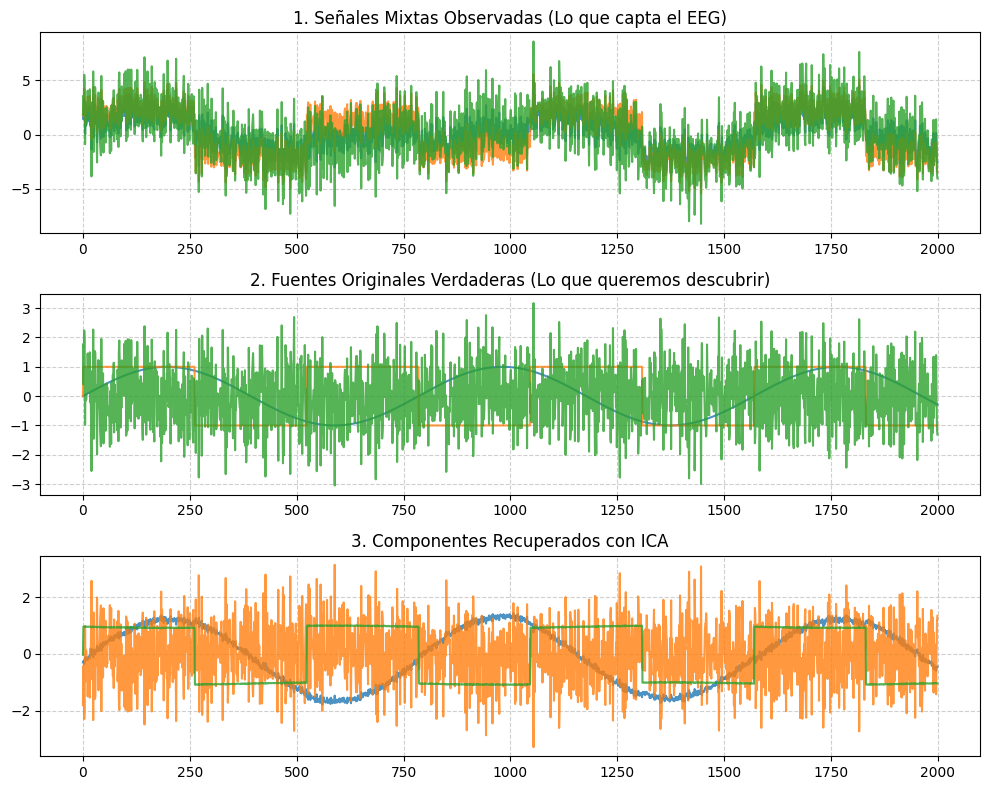

In [13]:
#============================================================
#                   ICA
#============================================================

np.random.seed(0)
time = np.linspace(0, 8, 2000)


s1 = np.sin(2 * time) 
s2 = np.sign(np.sin(3 * time))  
s3 = np.random.normal(size=s1.shape)  
S = np.c_[s1, s2, s3]


A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  
X = np.dot(S, A.T)


ica = FastICA(n_components=3, random_state=0)
S_recuperado = ica.fit_transform(X) 


plt.figure(figsize=(10, 8))
modelos = [X, S, S_recuperado]
nombres = ['1. Señales Mixtas Observadas (Lo que capta el EEG)',
        '2. Fuentes Originales Verdaderas (Lo que queremos descubrir)',
        '3. Componentes Recuperados con ICA']
colores = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, (modelo, nombre) in enumerate(zip(modelos, nombres), 1):
    plt.subplot(3, 1, i)
    plt.title(nombre, fontsize=12)
    for sig, color in zip(modelo.T, colores):
        plt.plot(sig, color=color, alpha=0.8)
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()